In [1]:
import numpy as np
import os
import h5py
from numpy import linalg as LA

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from scipy import spatial

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image

# Tensorflow version

## VGG feature extractor

In [2]:
# Load pre-trained VGG16 model without the final classification layers
# This gives us a feature extractor that outputs 512-dimensional vectors
model = VGG16(weights='imagenet',           # Use weights trained on ImageNet dataset
              input_shape=((224, 224, 3)), # Standard input size for VGG16 (224x224 RGB)
              pooling='max',               # Apply max pooling to reduce spatial dimensions
              include_top=False)           # Exclude the final fully-connected layers

# Display model architecture to understand the feature extraction pipeline
model.summary()
# The final output gives us a feature vector of size 512 for each input image

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
class VGGNet:
    """
    A wrapper class for VGG16 model to extract normalized feature vectors from images.
    This class handles image preprocessing and feature normalization for consistent results.
    """
    
    def __init__(self):
        """Initialize the VGG16 model with specific configuration for feature extraction."""
        # Configuration parameters for the model
        self.input_shape = (224, 224, 3)  # Required input dimensions for VGG16
        self.weight = 'imagenet'           # Use pre-trained ImageNet weights
        self.pooling = 'max'               # Max pooling for dimensionality reduction
        
        # Create the VGG16 model instance
        self.model = VGG16(weights=self.weight, 
                          input_shape=(self.input_shape[0], self.input_shape[1], self.input_shape[2]), 
                          pooling=self.pooling, 
                          include_top=False)
        
        # Warm up the model with a dummy prediction to ensure it's ready
        self.model.predict(np.zeros((1, 224, 224, 3)))
        
    def extract_feat(self, img_path):
        """
        Extract and normalize features from a single image.
        
        Args:
            img_path (str): Path to the input image file
            
        Returns:
            numpy.ndarray: Normalized 512-dimensional feature vector
        """
        # Load image and resize to required dimensions (224x224)
        img = image.load_img(img_path, target_size=(self.input_shape[0], self.input_shape[1]))
        
        # Convert PIL image to numpy array
        img = image.img_to_array(img)
        
        # Add batch dimension (convert from (224,224,3) to (1,224,224,3))
        img = np.expand_dims(img, axis=0)
        
        # Apply VGG16-specific preprocessing (normalize pixel values)
        img = preprocess_input(img)
        
        # Extract features using the pre-trained model
        feat = self.model.predict(img)
        
        # Normalize the feature vector to unit length for consistent similarity calculations
        # This ensures cosine similarity works properly
        norm_feat = feat[0] / LA.norm(feat[0])
        
        return norm_feat

## Index using VGG16 pretrained

In [4]:
print("  start feature extraction ")
model = VGGNet()  # Create feature extractor instance

# Define path to directory containing database images
path = "images/base/"
feats = []  # List to store extracted features
names = []  # List to store corresponding image names

# Process each image in the database directory
for im in os.listdir(path):
    print("Extracting features from image - ", im)
    
    # Extract normalized feature vector for current image
    X = model.extract_feat(path + im)
    feats.append(X)      # Store feature vector
    names.append(im)     # Store image filename
    
# Convert feature list to numpy array for efficient processing
feats = np.array(feats)

# HDF5 format is efficient for storing large numerical datasets
output = "CNNFeatures.h5"
print(" writing feature extraction results to h5 file")

# Create HDF5 file and save both features and filenames
h5f = h5py.File(output, 'w')
h5f.create_dataset('dataset_1', data=feats)              # Save feature vectors
h5f.create_dataset('dataset_2', data=np.bytes_(names))   # Save filenames as bytes
h5f.close()

  start feature extraction 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Extracting features from image -  car-1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Extracting features from image -  car-2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Extracting features from image -  tiger-1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Extracting features from image -  tiger-2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Extracting features from image -  truck-1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Extracting features from image -  truck-2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Extracting features from image -  zebra-1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Extracting features from image -  zebra-2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
 writing feature extraction results to h5 file


## Query using VGG16 features with visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Top 3 matches with similarity scores:
1. Image: car-1.jpg, Score: 0.6984
2. Image: truck-2.jpg, Score: 0.6398
3. Image: car-2.jpg, Score: 0.5944


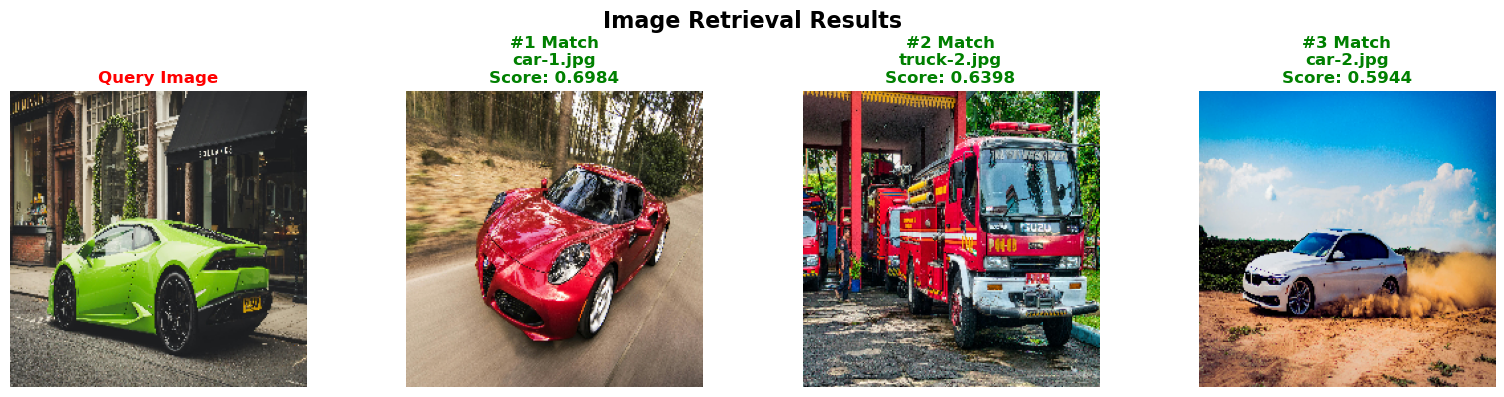

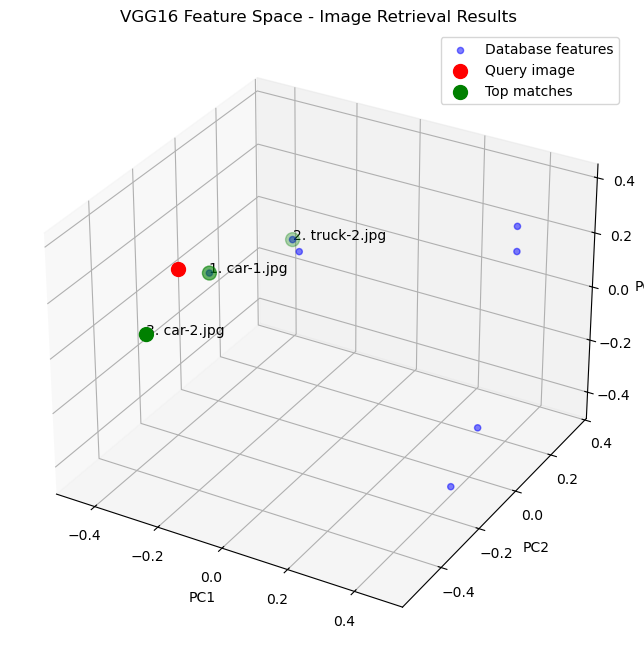

In [5]:
def plot_feature_space(features, query_feat, top_matches, imgNames, title="Feature Space Visualization"):
    """
    Visualize high-dimensional feature vectors in 3D space using PCA dimensionality reduction.
    
    This function helps understand how similar images cluster together in feature space.
    
    Args:
        features: Database feature vectors (N x 512)
        query_feat: Query image feature vector (512,)
        top_matches: Indices of best matching images
        imgNames: List of image filenames
        title: Plot title
    """
    # Use PCA to reduce 512 dimensions to 3 for visualization
    pca = PCA(n_components=3)
    
    # Combine query and database features for consistent PCA transformation
    all_features = np.vstack([features, query_feat.reshape(1, -1)])
    features_3d = pca.fit_transform(all_features)
    
    # Split the transformed features back into database and query
    db_features_3d = features_3d[:-1]    # All but last (database features)
    query_feature_3d = features_3d[-1]   # Last feature (query)
    
    # Create 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot all database images as blue points
    ax.scatter(db_features_3d[:, 0], db_features_3d[:, 1], db_features_3d[:, 2], 
              c='blue', alpha=0.5, label='Database features')
    
    # Highlight query image as red point
    ax.scatter(query_feature_3d[0], query_feature_3d[1], query_feature_3d[2], 
              c='red', s=100, label='Query image')
    
    # Highlight top matching images as green points
    matches_3d = db_features_3d[top_matches]
    ax.scatter(matches_3d[:, 0], matches_3d[:, 1], matches_3d[:, 2], 
              c='green', s=100, label='Top matches')
    
    # Add text labels for top matches showing rank and filename
    for i, match_idx in enumerate(top_matches):
        # Handle both string and bytes filenames
        img_name = imgNames[match_idx].decode('utf-8') if isinstance(imgNames[match_idx], bytes) else imgNames[match_idx]
        ax.text(matches_3d[i, 0], matches_3d[i, 1], matches_3d[i, 2], f'{i+1}. {img_name}')
    
    # Set axis labels and plot properties
    ax.set_xlabel('PC1')  # First Principal Component
    ax.set_ylabel('PC2')  # Second Principal Component
    ax.set_zlabel('PC3')  # Third Principal Component
    ax.set_title(title)
    ax.legend()
    plt.show()

# Load previously saved features from HDF5 file
h5f = h5py.File("CNNFeatures.h5", 'r')
feats = h5f['dataset_1'][:]      # Load feature vectors
imgNames = h5f['dataset_2'][:]   # Load image filenames
h5f.close()

# Define query image path
queryImg = "images/query/car-3.jpg"

# Extract features from query image
model = VGGNet()
query_feat = model.extract_feat(queryImg)

scores = []  # List to store similarity scores

# Compare query features with each database image
for i in range(feats.shape[0]):
    # Calculate cosine similarity (1 - cosine_distance)
    # Cosine similarity ranges from -1 to 1, where 1 means identical direction
    score = 1 - spatial.distance.cosine(query_feat, feats[i])
    scores.append(score)

scores = np.array(scores)

# Sort images by similarity score in descending order (best matches first)
rank_ID = np.argsort(scores)[::-1]  # Get indices sorted by descending score
rank_score = scores[rank_ID]        # Get sorted scores

# Get top N matches for display
top_n = 3
top_matches = rank_ID[:top_n]       # Indices of top matching images
top_scores = rank_score[:top_n]     # Corresponding similarity scores

# Display results
print(f"Top {top_n} matches with similarity scores:")
for i, (image_id, score) in enumerate(zip(top_matches, top_scores)):
    # Handle both string and bytes filenames for display
    image_name = imgNames[image_id].decode('utf-8') if isinstance(imgNames[image_id], bytes) else imgNames[image_id]
    print(f"{i+1}. Image: {image_name}, Score: {score:.4f}")

def display_results(query_path, top_matches, top_scores, imgNames, db_path="images/base/"):
    """
    Display the query image alongside the top matching images with their similarity scores.
    
    Args:
        query_path: Path to the query image
        top_matches: Indices of top matching images
        top_scores: Similarity scores for top matches
        imgNames: Array of image filenames
        db_path: Path to database images directory
    """
    # Create subplot grid: 1 row, 4 columns (query + 3 matches)
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle('Image Retrieval Results', fontsize=16, fontweight='bold')
    
    # Display query image
    query_img = image.load_img(query_path, target_size=(224, 224))
    axes[0].imshow(query_img)
    axes[0].set_title('Query Image', fontweight='bold', color='red')
    axes[0].axis('off')
    
    # Display top 3 matching images
    for i, (match_idx, score) in enumerate(zip(top_matches, top_scores)):
        # Get image filename (handle both string and bytes)
        img_name = imgNames[match_idx].decode('utf-8') if isinstance(imgNames[match_idx], bytes) else imgNames[match_idx]
        
        # Load and display matching image
        match_img = image.load_img(db_path + img_name, target_size=(224, 224))
        axes[i+1].imshow(match_img)
        
        # Set title with rank, filename, and similarity score
        axes[i+1].set_title(f'#{i+1} Match\n{img_name}\nScore: {score:.4f}', 
                           fontweight='bold', color='green')
        axes[i+1].axis('off')
    
    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

# Display the query image and top 3 similar images with scores
display_results(queryImg, top_matches, top_scores, imgNames)

# Create 3D visualization showing query image, database images, and top matches
plot_feature_space(feats, query_feat, top_matches, imgNames, 
                  "VGG16 Feature Space - Image Retrieval Results")

# Pytorch

In [6]:
# Check if CUDA is available for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# PyTorch offers multiple models including VGG16 and ResNet
# Choose which model to use for feature extraction

MODEL_CHOICE = "vgg16"  # Options: "vgg16", "resnet50"

if MODEL_CHOICE == "vgg16":
    # Load pre-trained VGG16 model
    base_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    
    # Choose feature extraction point:
    USE_FC_FEATURES = True  # Set to True for 4096-dim, False for 512-dim (like TensorFlow)
    
    if USE_FC_FEATURES:
        # Extract from first FC layer (4096 features) - more detailed
        model = nn.Sequential(
            base_model.features,           # Convolutional layers
            base_model.avgpool,           # Adaptive average pooling
            nn.Flatten(),                 # Flatten to 1D vector
            *list(base_model.classifier.children())[:-3]  # First FC layer only
        )
        feature_dim = 4096
        print("VGG16 model loaded - using FC layer features (4096-dim)")
    else:
        # Extract from conv layers after pooling (512 features) - same as TensorFlow
        model = nn.Sequential(
            base_model.features,          # Convolutional layers  
            nn.AdaptiveAvgPool2d((1, 1)), # Global average pooling
            nn.Flatten()                  # Flatten to get 512 features
        )
        feature_dim = 512
        print("VGG16 model loaded - using pooled conv features (512-dim, same as TensorFlow)")
    
elif MODEL_CHOICE == "resnet50":
    # Load pre-trained ResNet-50 model 
    base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT )
    
    # Remove the final fully connected layer to get feature representations
    # ResNet-50 without FC layer outputs 2048-dimensional features
    model = nn.Sequential(*list(base_model.children())[:-1])
    feature_dim = 2048
    print("ResNet-50 model loaded successfully")

else:
    raise ValueError("MODEL_CHOICE must be either 'vgg16' or 'resnet50'")

model = model.to(device)
model.eval()  # Set to evaluation mode (disables dropout, batch norm updates)

print(f"Feature dimension: {feature_dim}")

VGG16 model loaded - using FC layer features (4096-dim)
Feature dimension: 4096


In [8]:
# Define image preprocessing transformations following ImageNet standards
transform = transforms.Compose([
    transforms.Resize(256),                    # Resize shorter side to 256 pixels
    transforms.CenterCrop(224),                # Center crop to 224x224 (ResNet and vgg16 input size)
    transforms.ToTensor(),                     # Convert PIL image to tensor [0,1]
    transforms.Normalize(                      # Normalize with ImageNet statistics
        mean=[0.485, 0.456, 0.406],          # ImageNet mean for RGB channels
        std=[0.229, 0.224, 0.225]            # ImageNet std for RGB channels
    )
])

In [9]:
class FeatureExtractor:
    """
    A wrapper class for CNN models to extract normalized feature vectors from images.
    Supports both VGG16 and ResNet-50 architectures.
    """
    
    def __init__(self, model, transform, device, feature_dim):
        """
        Initialize the feature extractor.
        
        Args:
            model: Pre-trained CNN model
            transform: Image preprocessing pipeline
            device: Device to run inference on (CPU or CUDA)
            feature_dim: Dimension of output features
        """
        self.model = model
        self.transform = transform
        self.device = device
        self.feature_dim = feature_dim
        
    def extract_feat(self, img_path):
        """
        Extract and normalize features from a single image.
        
        Args:
            img_path (str): Path to the input image file
            
        Returns:
            numpy.ndarray: Normalized feature vector
        """
        try:
            # Load image using PIL
            img = Image.open(img_path).convert('RGB')  # Ensure RGB format
            
            # Apply preprocessing transformations
            img_tensor = self.transform(img).unsqueeze(0)  # Add batch dimension
            img_tensor = img_tensor.to(self.device)        # Move to device (GPU/CPU)
            
            # Extract features without gradient computation (inference mode)
            with torch.no_grad():
                features = self.model(img_tensor)
            
            # Handle different output shapes
            if len(features.shape) > 2:  # For models that output spatial features
                features = features.squeeze()  # Remove batch and spatial dims
            else:  # For models that output flattened features
                features = features.squeeze()  # Remove batch dimension only
            
            # Convert to numpy
            features = features.cpu().numpy()
            
            # Normalize to unit vector for consistent similarity calculations
            norm_features = features / np.linalg.norm(features)
            
            return norm_features
            
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            return None

In [10]:
print("Starting feature extraction...")
feature_extractor = FeatureExtractor(model, transform, device, feature_dim)

# Define path to directory containing database images
path = "images/base/"
feats = []  # List to store extracted features
names = []  # List to store corresponding image names

# Process each image in the database directory
for im in os.listdir(path):
    # Skip non-image files
    if not im.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        continue
        
    print(f"Extracting features from image - {im}")
    
    # Extract normalized feature vector for current image
    feature_vector = feature_extractor.extract_feat(path + im)
    
    if feature_vector is not None:
        feats.append(feature_vector)  # Store feature vector
        names.append(im)              # Store image filename
    else:
        print(f"Skipped {im} due to processing error")

# Convert feature list to numpy array for efficient processing
feats = np.array(feats)
print(f"Extracted features from {len(feats)} images")
print(f"Feature shape: {feats.shape}")


# HDF5 format is efficient for storing large numerical datasets
output = "PyTorchFeatures.h5"
print("Writing feature extraction results to h5 file")

# Create HDF5 file and save both features and filenames
h5f = h5py.File(output, 'w')
h5f.create_dataset('dataset_1', data=feats)              # Save feature vectors
h5f.create_dataset('dataset_2', data=np.bytes_(names))   # Save filenames as bytes
h5f.close()

Starting feature extraction...
Extracting features from image - car-1.jpg
Extracting features from image - car-2.jpg
Extracting features from image - tiger-1.jpg
Extracting features from image - tiger-2.jpg
Extracting features from image - truck-1.jpg
Extracting features from image - truck-2.jpg
Extracting features from image - zebra-1.jpg
Extracting features from image - zebra-2.jpg
Extracted features from 8 images
Feature shape: (8, 4096)
Writing feature extraction results to h5 file


In [11]:
def plot_feature_space(features, query_feat, top_matches, imgNames, title="Feature Space Visualization"):
    """
    Visualize high-dimensional feature vectors in 3D space using PCA dimensionality reduction.
    
    This function helps understand how similar images cluster together in feature space.
    
    Args:
        features: Database feature vectors (N x 2048)
        query_feat: Query image feature vector (2048,)
        top_matches: Indices of best matching images
        imgNames: List of image filenames
        title: Plot title
    """
    # Use PCA to reduce 2048 dimensions to 3 for visualization
    pca = PCA(n_components=3)
    
    # Combine query and database features for consistent PCA transformation
    all_features = np.vstack([features, query_feat.reshape(1, -1)])
    features_3d = pca.fit_transform(all_features)
    
    # Split the transformed features back into database and query
    db_features_3d = features_3d[:-1]    # All but last (database features)
    query_feature_3d = features_3d[-1]   # Last feature (query)
    
    # Create 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot all database images as blue points
    ax.scatter(db_features_3d[:, 0], db_features_3d[:, 1], db_features_3d[:, 2], 
              c='blue', alpha=0.5, label='Database features')
    
    # Highlight query image as red point
    ax.scatter(query_feature_3d[0], query_feature_3d[1], query_feature_3d[2], 
              c='red', s=100, label='Query image')
    
    # Highlight top matching images as green points
    matches_3d = db_features_3d[top_matches]
    ax.scatter(matches_3d[:, 0], matches_3d[:, 1], matches_3d[:, 2], 
              c='green', s=100, label='Top matches')
    
    # Add text labels for top matches showing rank and filename
    for i, match_idx in enumerate(top_matches):
        # Handle both string and bytes filenames
        img_name = imgNames[match_idx].decode('utf-8') if isinstance(imgNames[match_idx], bytes) else imgNames[match_idx]
        ax.text(matches_3d[i, 0], matches_3d[i, 1], matches_3d[i, 2], f'{i+1}. {img_name}')
    
    # Set axis labels and plot properties
    ax.set_xlabel('PC1')  # First Principal Component
    ax.set_ylabel('PC2')  # Second Principal Component
    ax.set_zlabel('PC3')  # Third Principal Component
    ax.set_title(title)
    ax.legend()
    
    # Display explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print(f"PCA Explained Variance Ratio: {explained_variance}")
    print(f"Total variance explained: {sum(explained_variance):.3f}")
    
    plt.show()

In [12]:
# Load previously saved features from HDF5 file
h5f = h5py.File("PyTorchFeatures.h5", 'r')
feats = h5f['dataset_1'][:]      # Load feature vectors
imgNames = h5f['dataset_2'][:]   # Load image filenames
h5f.close()

# Define query image path
queryImg = "images/query/car-3.jpg"

# Extract features from query image
query_feat = feature_extractor.extract_feat(queryImg)

if query_feat is None:
    print("Error: Could not extract features from query image")
    exit()

print(f"Query feature shape: {query_feat.shape}")

scores = []  # List to store similarity scores

# Compare query features with each database image
for i in range(feats.shape[0]):
    # Calculate cosine similarity (1 - cosine_distance)
    # Cosine similarity ranges from -1 to 1, where 1 means identical direction
    score = 1 - spatial.distance.cosine(query_feat, feats[i])
    scores.append(score)

scores = np.array(scores)

# Sort images by similarity score in descending order (best matches first)
rank_ID = np.argsort(scores)[::-1]  # Get indices sorted by descending score
rank_score = scores[rank_ID]        # Get sorted scores

# Get top N matches for display
top_n = 3
top_matches = rank_ID[:top_n]       # Indices of top matching images
top_scores = rank_score[:top_n]     # Corresponding similarity scores

# Display results
print(f"\nTop {top_n} matches with similarity scores:")
for i, (image_id, score) in enumerate(zip(top_matches, top_scores)):
    # Handle both string and bytes filenames for display
    image_name = imgNames[image_id].decode('utf-8') if isinstance(imgNames[image_id], bytes) else imgNames[image_id]
    print(f"{i+1}. Image: {image_name}, Score: {score:.4f}")

Query feature shape: (4096,)

Top 3 matches with similarity scores:
1. Image: car-1.jpg, Score: 0.7568
2. Image: car-2.jpg, Score: 0.6347
3. Image: tiger-1.jpg, Score: 0.6056


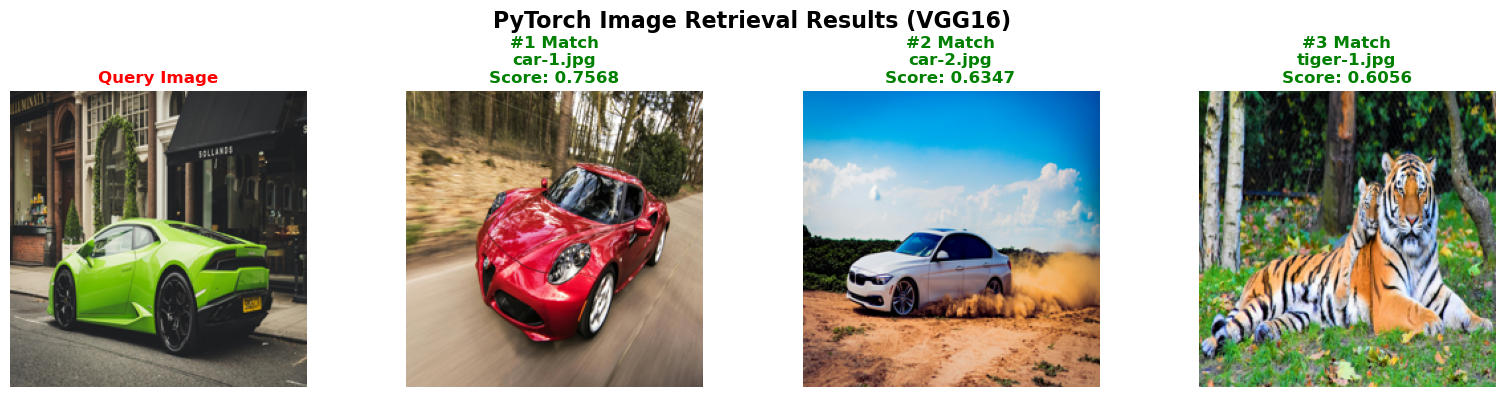

PCA Explained Variance Ratio: [0.34669968 0.21572638 0.14011504]
Total variance explained: 0.703


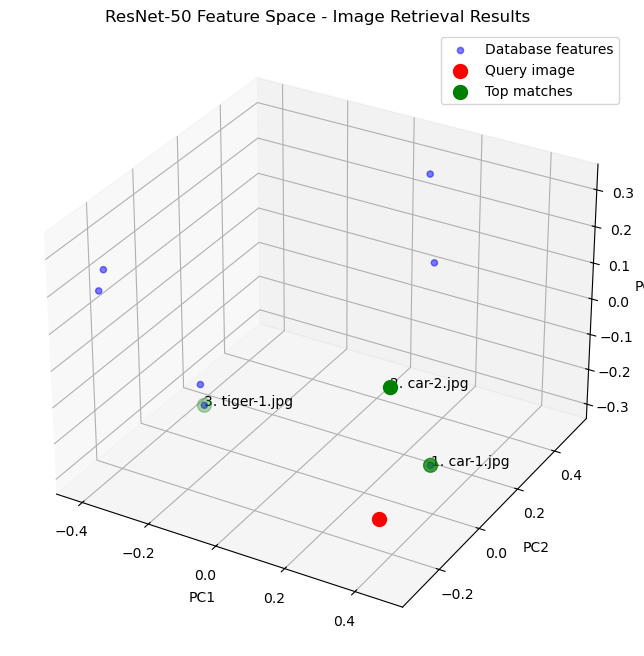


PERFORMANCE SUMMARY
Model: VGG16 (pre-trained on ImageNet)
Feature dimension: 4096
Database size: 8 images
Device used: cuda
Query image: images/query/car-3.jpg
Best match: car-1.jpg
Best similarity score: 0.7568


In [13]:
def display_results(query_path, top_matches, top_scores, imgNames, db_path="images/base/"):
    """
    Display the query image alongside the top matching images with their similarity scores.
    
    Args:
        query_path: Path to the query image
        top_matches: Indices of top matching images
        top_scores: Similarity scores for top matches
        imgNames: Array of image filenames
        db_path: Path to database images directory
    """
    # Create subplot grid: 1 row, 4 columns (query + 3 matches)
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle(f'PyTorch Image Retrieval Results ({MODEL_CHOICE.upper()})', fontsize=16, fontweight='bold')
    
    # Display query image
    query_img = Image.open(query_path).convert('RGB')
    query_img = query_img.resize((224, 224))  # Resize for consistent display
    axes[0].imshow(query_img)
    axes[0].set_title('Query Image', fontweight='bold', color='red')
    axes[0].axis('off')
    
    # Display top 3 matching images
    for i, (match_idx, score) in enumerate(zip(top_matches, top_scores)):
        # Get image filename (handle both string and bytes)
        img_name = imgNames[match_idx].decode('utf-8') if isinstance(imgNames[match_idx], bytes) else imgNames[match_idx]
        
        # Load and display matching image
        match_img = Image.open(db_path + img_name).convert('RGB')
        match_img = match_img.resize((224, 224))  # Resize for consistent display
        axes[i+1].imshow(match_img)
        
        # Set title with rank, filename, and similarity score
        axes[i+1].set_title(f'#{i+1} Match\n{img_name}\nScore: {score:.4f}', 
                           fontweight='bold', color='green')
        axes[i+1].axis('off')
    
    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

# Display the query image and top 3 similar images with scores
display_results(queryImg, top_matches, top_scores, imgNames)

# Create 3D visualization showing query image, database images, and top matches
plot_feature_space(feats, query_feat, top_matches, imgNames, 
                  "ResNet-50 Feature Space - Image Retrieval Results")

# Performance summary
print(f"\n{'='*50}")
print("PERFORMANCE SUMMARY")
print(f"{'='*50}")
print(f"Model: {MODEL_CHOICE.upper()} (pre-trained on ImageNet)")
print(f"Feature dimension: {query_feat.shape[0]}")
print(f"Database size: {len(feats)} images")
print(f"Device used: {device}")
print(f"Query image: {queryImg}")
print(f"Best match: {imgNames[top_matches[0]].decode('utf-8') if isinstance(imgNames[top_matches[0]], bytes) else imgNames[top_matches[0]]}")
print(f"Best similarity score: {top_scores[0]:.4f}")
print(f"{'='*50}")